In [1]:
# Loading necessary packages
import pandas as pd
import numpy as np

from pathlib import Path
import tifffile as TIFF
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage as ndi
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [9]:
try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        "nearest": pil_image.NEAREST,
        "bilinear": pil_image.BILINEAR,
        "bicubic": pil_image.BICUBIC,
        "hamming": pil_image.HAMMING,
        "box": pil_image.BOX,
        "lanczos": pil_image.LANCZOS,
    }

#### Loading functions for processing of multiclass masks

In [2]:
from src.utils.connected_components import get_neighbours, dfs, apply_correction

In [3]:
label_dict = {
                'class 2: RBC/WBC' : 2,
                'class 1: rod' : 1,
                'class 4: misc' : 4,
                'class 5: single EPC' : 5,
                'class 3: yeast' : 3,
                'class 6: few EPC ' : 6,
                'class 7: several EPC' : 7
            }

#### Reading and converting sample csv to multiclass mask

In [6]:
# Reading multiclass dataset
multiclass_df = pd.read_csv("../../../ds1_multiclass/test/labels.csv", header=0)
multiclass_df = multiclass_df.drop(['Unnamed: 0'], axis=1)
print(multiclass_df)

                 label  area         x        y            img
0     class 2: RBC/WBC   281   401.429   47.877   130 G 261021
1     class 2: RBC/WBC   340    40.965   57.303   130 G 261021
2     class 2: RBC/WBC   282    89.986   77.050   130 G 261021
3     class 2: RBC/WBC   131   288.263   87.531   130 G 261021
4         class 1: rod    34   289.500  165.588   130 G 261021
...                ...   ...       ...      ...            ...
3114      class 1: rod    25   470.180  958.980  6189 J 051021
3115      class 1: rod    16  1080.125  961.062  6189 J 051021
3116      class 1: rod    30   575.167  964.300  6189 J 051021
3117      class 1: rod    16   894.000  964.000  6189 J 051021
3118      class 1: rod    27   868.130  966.019  6189 J 051021

[3119 rows x 5 columns]


In [7]:
# Maximum number of objects in any given image
multiclass_df.groupby('img').apply(lambda pdf: len(pdf)).max() 

428

In [8]:
# Number of objects per image
multiclass_df.groupby('img').apply(lambda pdf: len(pdf))

img
130 G 261021      29
130 V 261021      32
4617 F 051021      5
5821 C 280921      3
5830 H 061021      2
                ... 
8475 X 261021    113
8477 I 261021      1
8502 E 031121      2
8530 Z 161121    258
8540 B 261021      3
Length: 91, dtype: int64

In [9]:
# Number of unique objects across files
print(multiclass_df.shape)

(3119, 5)


In [10]:
# Number of unique classes of labels
len(multiclass_df['label'].unique())

7

In [11]:
# Number of unique images in 'test' labelled for multiclass
img_ls = list(multiclass_df['img'].unique())
len(img_ls)

91

(1040, 1392)


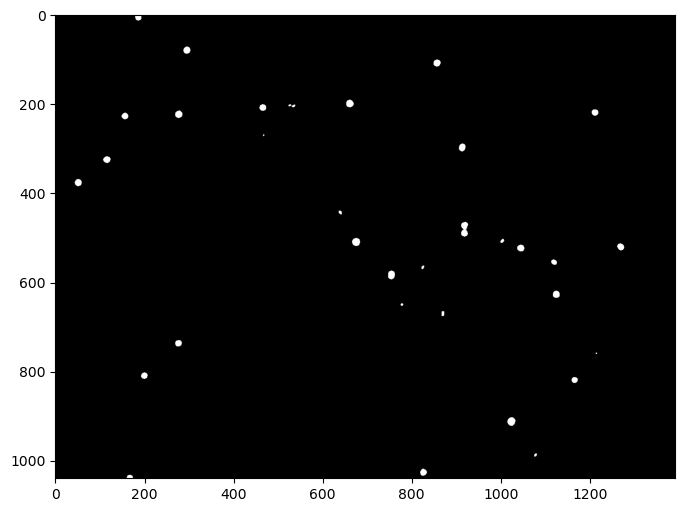

In [12]:
# Example binary mask visualization
image_folder = Path("../../../ds1/test/man_mask/cls/")

image_path = image_folder / (img_ls[1] + '_Simple Segmentation.tif')
img = TIFF.imread(image_path)
print(img.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap=plt.cm.gray)
plt.show()

In [13]:
# Size of connected component starting from (i,j) pixel location
pixel_ls, count  = dfs(img,j=round(206.076),
                       i = round(535.803),
                       width = img.shape[1],
                       height = img.shape[0])

print(count)

53


In [14]:
# Making identified pixel of connected component into list
pixel_array = np.array([*pixel_ls])
pixel_array = np.fliplr(pixel_array)
print(pixel_array.shape)

(53, 2)


In [15]:
# Creating 3-channel version of image
img2 = np.empty((img.shape[0],img.shape[1],3))
print(img2.shape)
img2[:,:,0] = img
img2[:,:,1] = img
img2[:,:,2] = img



(1040, 1392, 3)


In [16]:
# Ensuring that it is a black and white image
np.unique(img2)

array([  0., 255.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


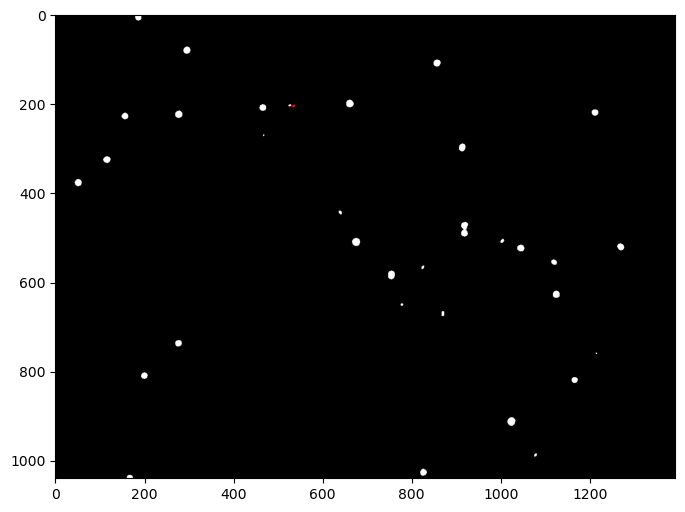

In [17]:
# Marking pixels identified as part of connected component 'Red'
for pixel in pixel_array:
    img2[pixel[1]][pixel[0]] = [255,0,0]
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img2)
plt.show()

In [18]:
# Let us assign 7 colours to the 7 of the classes that we have
# Later we will also assign numbers to them

print(multiclass_df['label'].unique())
colour_dict = {
                'class 2: RBC/WBC' : [0,255,255],
                'class 1: rod' : [255,0,0],
                'class 4: misc' : [255,64,64],
                'class 5: single EPC' : [127,255,0],
                'class 3: yeast' : [191,62,255],
                'class 6: few EPC ' : [255,127,36],
                'class 7: several EPC' : [139,136,120]
            }


['class 2: RBC/WBC' 'class 1: rod' 'class 4: misc' 'class 5: single EPC'
 'class 3: yeast' 'class 6: few EPC ' 'class 7: several EPC']


(1040, 1392)


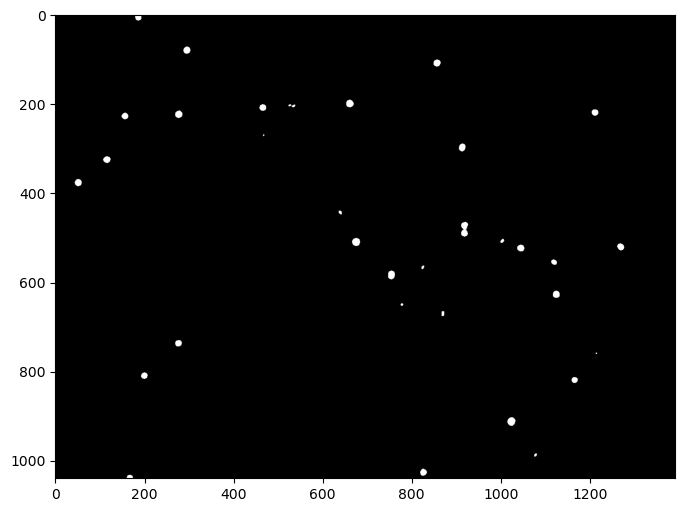

In [19]:
# Taking another example binary mask
image_folder = Path("../../../ds1/test/man_mask/cls/")

image_path = image_folder / (img_ls[1] + '_Simple Segmentation.tif')
img = TIFF.imread(image_path)
print(img.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap=plt.cm.gray)
plt.show()

In [20]:
# Finding centroids of multiclass objects labelled in this example binary mask
temp = multiclass_df.loc[multiclass_df['img']=="4617 F 051021"]
xy_ls = list(zip(list(temp['x']),list(temp['y'])))
label_ls = list(temp['label'])
print(xy_ls)
print(label_ls)

[(1221.015, 182.6), (827.312, 349.565), (205.407, 662.779), (70.585, 771.054), (567.095, 909.868)]
['class 5: single EPC', 'class 5: single EPC', 'class 4: misc', 'class 5: single EPC', 'class 5: single EPC']


In [21]:
# labels corresponding to these labelled multiclass objects
np.unique(label_ls)

array(['class 4: misc', 'class 5: single EPC'], dtype='<U19')

In [22]:
# Excuting the above steps for an example mask up to colouring individual objects of different 
# classes a different colours
image_path = image_folder / ('4617 F 051021' + '_Simple Segmentation.tif')
img = TIFF.imread(image_path)
print(img.shape)

img2 = np.empty((img.shape[0],img.shape[1],3))
print(img2.shape)
img2[:,:,0] = img
img2[:,:,1] = img
img2[:,:,2] = img

(1040, 1392)
(1040, 1392, 3)


In [23]:
for k in range(len(xy_ls)):
    x,y = xy_ls[k]
    pixel_ls, count  = dfs(img,j=round(y),
                       i = round(x),
                       width = img.shape[1],
                       height = img.shape[0])
    pixel_array = np.array([*pixel_ls])
    pixel_array = np.fliplr(pixel_array)
    for pixel in pixel_array:
        img2[pixel[1]][pixel[0]] = colour_dict[label_ls[k]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


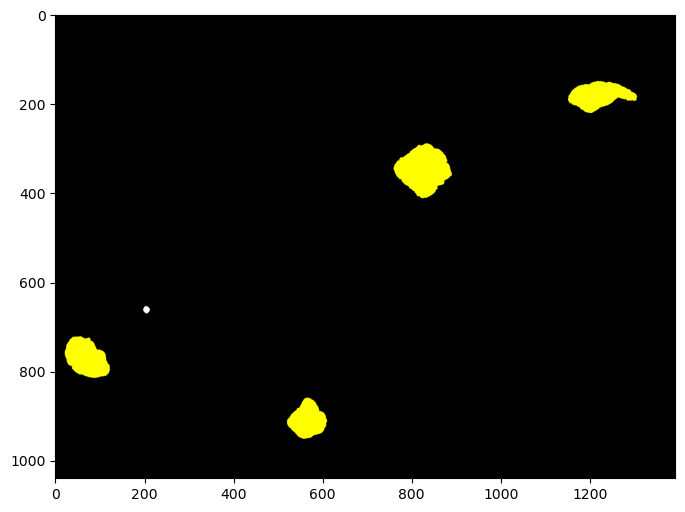

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img2)
plt.show()

In [25]:
np.unique(img2) 
# Here we may see 255 as one of the numbers since there can be object such as debris 
# that are present as a connected component but not an object belonging to one of the classes

array([  0.,  64., 127., 255.])

(1040, 1392, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


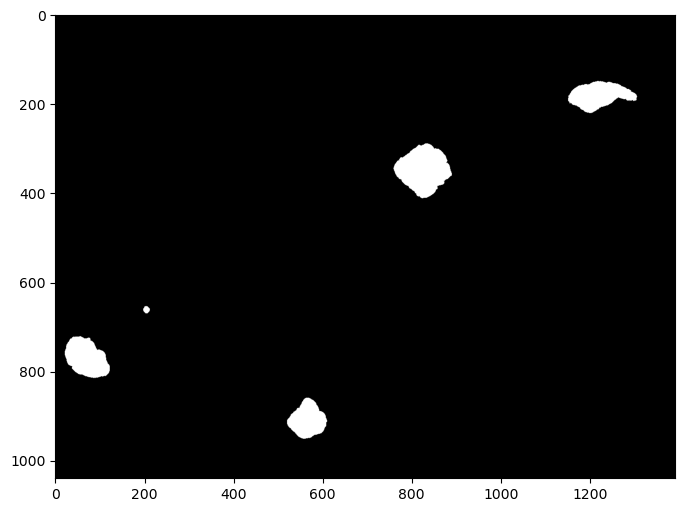

In [26]:
#Assigning different number labels to the connected components according to label_dict
img2 = np.empty((img.shape[0],img.shape[1],3))
print(img2.shape)
img2[:,:,0] = img
img2[:,:,1] = img
img2[:,:,2] = img

for k in range(len(xy_ls)):
    x,y = xy_ls[k]
    pixel_ls, count  = dfs(img,j=round(y),
                       i = round(x),
                       width = img.shape[1],
                       height = img.shape[0])
    pixel_array = np.array([*pixel_ls])
    pixel_array = np.fliplr(pixel_array)
    for pixel in pixel_array:
        img2[pixel[1]][pixel[0]] = label_dict[label_ls[k]]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img2)
plt.show()

In [27]:
# Verifying that the correct numbers are assigned
np.unique(img2)

array([0., 4., 5.])

In [28]:
# This means that these are objects not in label_dict but not identifiedt
# We set them as background or 0 since they are not of interest to us
img2 = np.where(img2<1,0,img2) 
img2 = np.where(img2>7,0,img2)
np.unique(img2)

array([0., 4., 5.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


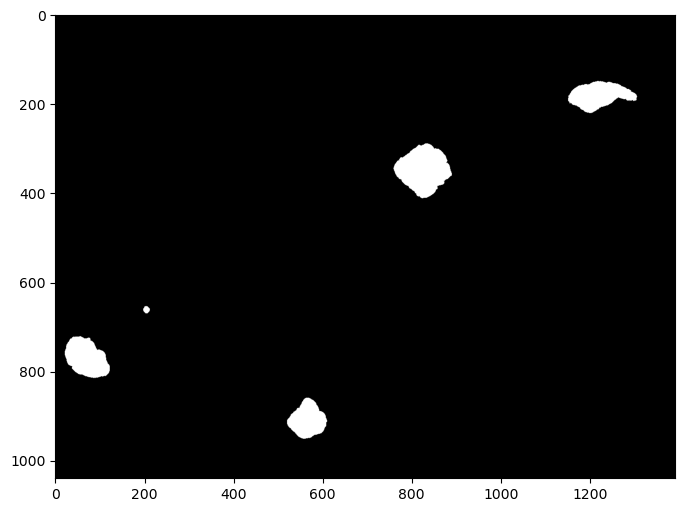

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img2)
plt.show()

#### Processing all the multiclass masks

In [17]:
#Now we need to process all the masks in all the csvs to get the corresponding multiclass masks

multiclass_data_path1 = Path("../../../ds1_multiclass/validation/")

files1 = multiclass_data_path1.glob('*.csv')

multiclass_df = pd.DataFrame()
for f in list(files1):
    df = pd.read_csv(f)
    df = df.drop(['Unnamed: 0'], axis=1)
    multiclass_df = pd.concat([multiclass_df,df])

print(multiclass_df.shape)

(2028, 5)


In [18]:
# Number of unique files identified
img_ls = list(multiclass_df['img'].unique())
len(img_ls)

98

In [19]:
# Processing of all binary masks in a certain split of the data
image_folder = Path("../../../ds1/validation/man_mask/cls/")
multiclass_output_mask_folder = Path("../../../ds1_multiclass/validation/man_mask/cls/")

for img_f in img_ls:
    if (multiclass_output_mask_folder / Path(img_f + '_Simple Segmentation.tif')).is_file():
        continue
    else:
        image_path = image_folder / (img_f + '_Simple Segmentation.tif')
        img = TIFF.imread(image_path)
        print(img.shape)

        img2 = np.empty((img.shape[0],img.shape[1],3))
        print(img2.shape)
        img2[:,:,0] = img
        img2[:,:,1] = img
        img2[:,:,2] = img

        temp = multiclass_df.loc[multiclass_df['img']==img_f]
        xy_ls = list(zip(list(temp['x']),list(temp['y'])))
        label_ls = list(temp['label'])
        print(np.unique(label_ls))

        for k in range(len(xy_ls)):
            x,y = xy_ls[k]
            pixel_ls, count  = dfs(img,j=round(y),
                            i = round(x),
                            width = img.shape[1],
                            height = img.shape[0])
            pixel_array = np.array([*pixel_ls])
            if len(pixel_array.shape)==2:
                pixel_array = np.fliplr(pixel_array)
            elif len(pixel_array.shape)==1:
                pixel_array = np.flip(pixel_array)

            for pixel in pixel_array:
                img2[pixel[1]][pixel[0]] = label_dict[label_ls[k]]

        img2 = np.where(img2<1,0,img2) # This means that these are objects not in label_dict but not identified
        img2 = np.where(img2>7,0,img2)
        print(np.unique(img2))

        # TIFF.imwrite(multiclass_output_mask_folder / (img_f + '_Simple Segmentation.tif'), img2[:,:,0].astype(np.uint8))
    

    

(1040, 1392)
(1040, 1392, 3)
['class 2: RBC/WBC' 'class 4: misc']
[0. 2. 4.]
(1040, 1392)
(1040, 1392, 3)
['class 1: rod' 'class 2: RBC/WBC' 'class 5: single EPC']
[0. 1. 2. 5.]
(1040, 1392)
(1040, 1392, 3)
['class 1: rod' 'class 2: RBC/WBC' 'class 4: misc' 'class 5: single EPC']
[0. 1. 2. 4. 5.]
(1040, 1392)
(1040, 1392, 3)
['class 1: rod' 'class 2: RBC/WBC' 'class 4: misc']
[0. 1. 2. 4.]
(1040, 1392)
(1040, 1392, 3)
['class 1: rod' 'class 2: RBC/WBC' 'class 6: few EPC ']
[0. 1. 2. 6.]
(1040, 1392)
(1040, 1392, 3)
['class 2: RBC/WBC' 'class 4: misc' 'class 5: single EPC']
[0. 2. 4. 5.]
(1040, 1392)
(1040, 1392, 3)
['class 1: rod' 'class 2: RBC/WBC']
[0. 1. 2.]
(1040, 1392)
(1040, 1392, 3)
['class 2: RBC/WBC' 'class 4: misc']
[0. 2. 4.]
(1040, 1392)
(1040, 1392, 3)
['class 5: single EPC']
[0. 5.]
(1040, 1392)
(1040, 1392, 3)
['class 2: RBC/WBC' 'class 5: single EPC']
[0. 2. 5.]
(1040, 1392)
(1040, 1392, 3)
['class 1: rod' 'class 2: RBC/WBC' 'class 4: misc' 'class 5: single EPC']
[0. 1.

#### Calculating area and circularity for manual labels 

In [30]:
from src.utils.circularity import picks_area, new_std_perimeter, modified_circ, get_corres_circularity

In [3]:
STREL_4 = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]], dtype=np.uint8)
STREL_8 = np.ones((3, 3), dtype=np.uint8)

In [8]:
# Creating corresponding dataset for morphological feature calculation
# from our labelled multiclass masks
multiclass_dir = Path("../../../ds1_multiclass/")
multiclass_folders = list(multiclass_dir.iterdir())
print(multiclass_folders)



[PosixPath('../../../ds1_multiclass/.DS_Store'), PosixPath('../../../ds1_multiclass/test'), PosixPath('../../../ds1_multiclass/train'), PosixPath('../../../ds1_multiclass/validation')]


In [9]:
multiclass_df_train = pd.DataFrame()
multiclass_df_val = pd.DataFrame()
multiclass_df_test = pd.DataFrame()

for folder in multiclass_folders:
    files = folder.glob('*.csv')
    for f in files:
        temp = pd.read_csv(f, header=0, index_col=None)
        print(temp.head())
        if 'train' in str(folder): 
            multiclass_df_train = pd.concat([multiclass_df_train,temp]) 
        elif 'validation' in str(folder):
            multiclass_df_val = pd.concat([multiclass_df_val,temp])    
        elif 'test' in str(folder):
            multiclass_df_test = pd.concat([multiclass_df_test,temp])

multiclass_df_train= get_corres_circularity(multiclass_df_train,split='train')
multiclass_df_val= get_corres_circularity(multiclass_df_val,split='validation')
multiclass_df_test= get_corres_circularity(multiclass_df_test,split='test')


print(multiclass_df_train)
print(multiclass_df_val)
print(multiclass_df_test)

            x           y  area           img             label
0  131.584158    4.935644   202  130 G 261021  class 2: RBC/WBC
1   89.986000   77.050000   282  130 G 261021  class 2: RBC/WBC
2  288.263000   87.531000   131  130 G 261021  class 2: RBC/WBC
3  289.500000  165.588000    34  130 G 261021      class 1: rod
4  914.188000  206.636000   308  130 G 261021  class 2: RBC/WBC
             x           y  area            img                label
0   495.085657   26.152353  4483  4499 E 030721  class 5: single EPC
1  1189.266000  480.172000   320  4499 E 030721        class 4: misc
2   510.536000  136.180000   253  4499 E 030721        class 4: misc
3  1308.109000   58.555000   289  4499 E 030721        class 4: misc
4   492.901000  775.461000   461  4499 E 030721     class 2: RBC/WBC
             x            y  area           img             label
0  1387.826087  1028.034783   115  130 T 310721  class 2: RBC/WBC
1   903.500000   227.000000    18  130 T 310721      class 1: rod
2   

In [10]:
df_list = [multiclass_df_train,multiclass_df_val,multiclass_df_test]

manually_labelled_df = pd.DataFrame()
for df in df_list:
    manually_labelled_df = pd.concat([manually_labelled_df,df])

print(manually_labelled_df.shape)

(7236, 6)


#### Showing example images of different groups in manual labels

In [14]:
#Reading multiclass dataset one again
#Choose test, validation, train. Combine into one df and all classes should be present there.

# Aggregating all the labels for the different data splits
multiclass_df = pd.DataFrame()

for f in multiclass_folders:
    if not str(f.stem).startswith('.'):
        split = f.parts[4] # Getting the split train/validation/test from path
        files = list(f.glob('*.csv'))
        print(files)
        temp_df = pd.read_csv(files[0], header=0, index_col=False)
        temp_df['split'] = split
        multiclass_df = pd.concat([multiclass_df,temp_df], axis=0)

print(multiclass_df.shape)

(1576, 5)


In [15]:
(multiclass_df['label'].unique())

array(['class 5: single EPC', 'class 4: misc', 'class 2: RBC/WBC',
       'class 1: rod', 'class 6: few EPC ', 'class 7: several EPC',
       'class 3: yeast'], dtype=object)

Cluster:  class 5: single EPC
Cluster:  class 4: misc
Cluster:  class 2: RBC/WBC
Cluster:  class 1: rod
Cluster:  class 6: few EPC 
Cluster:  class 7: several EPC
Cluster:  class 3: yeast


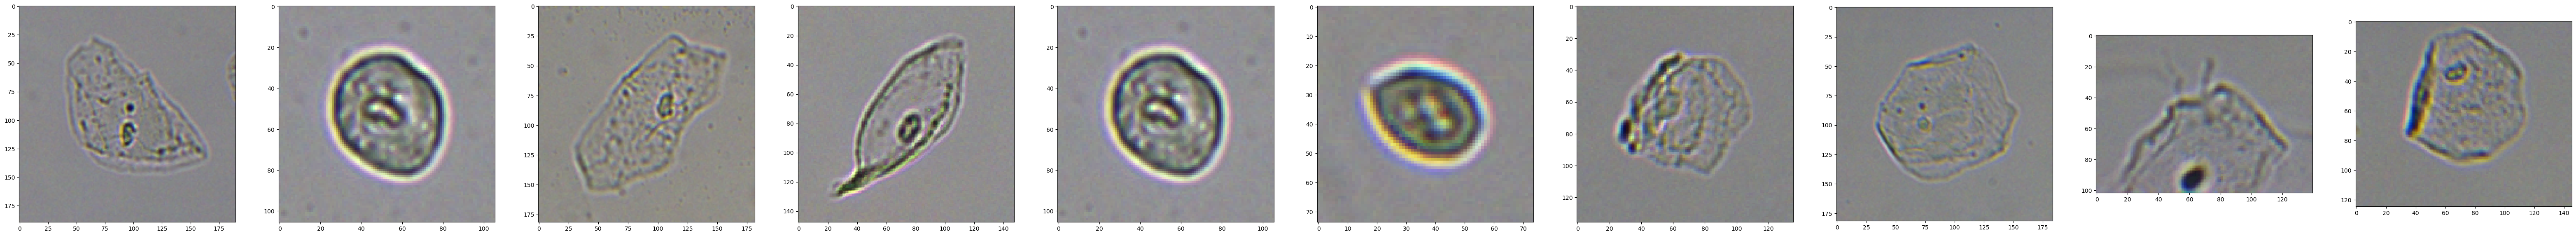

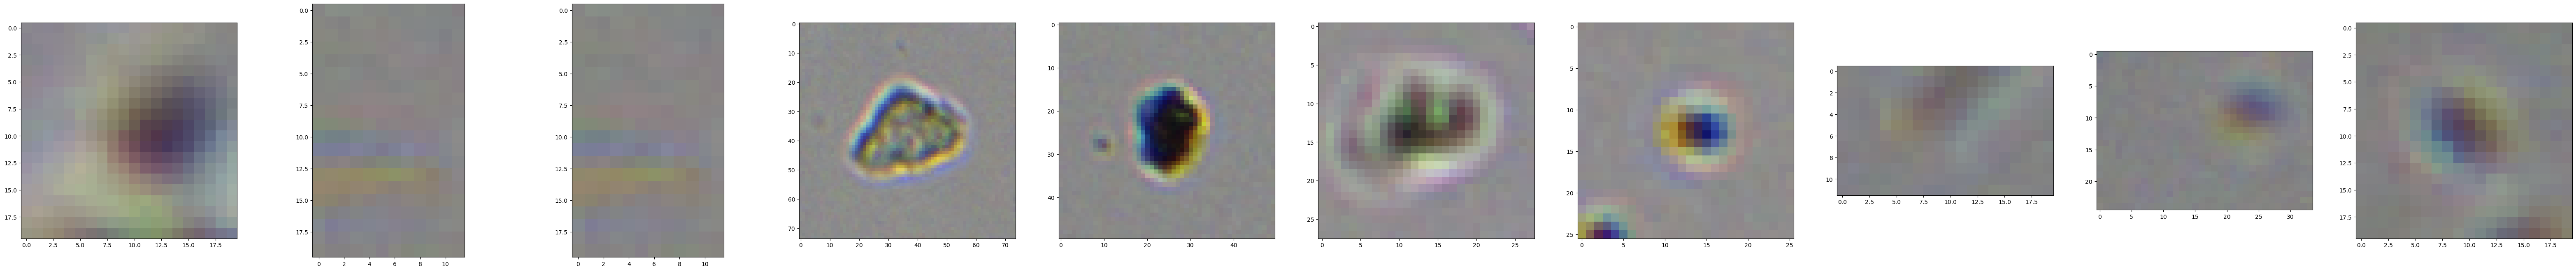

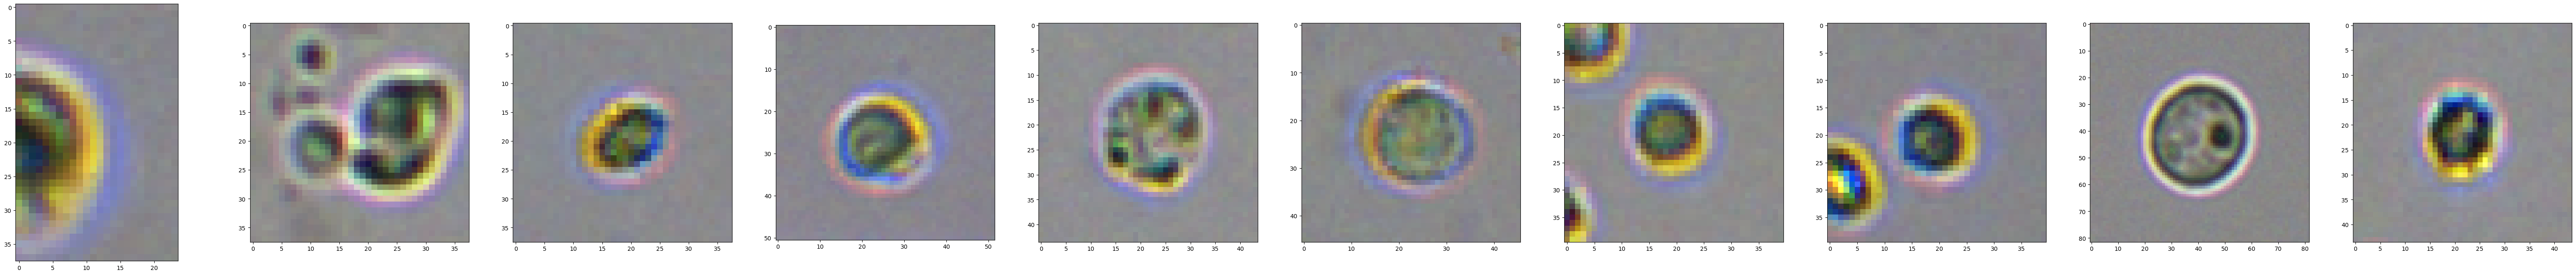

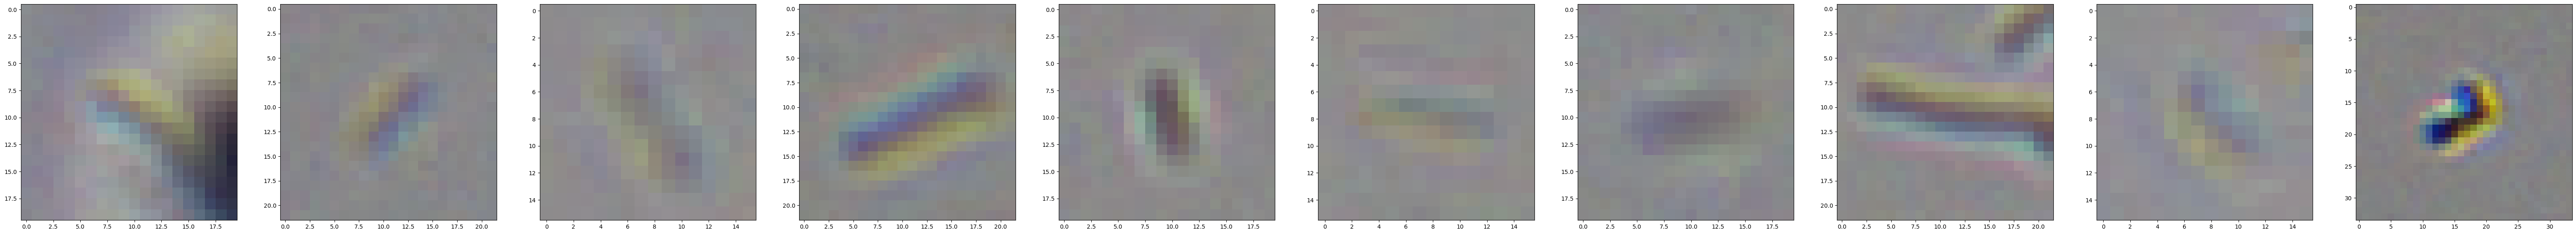

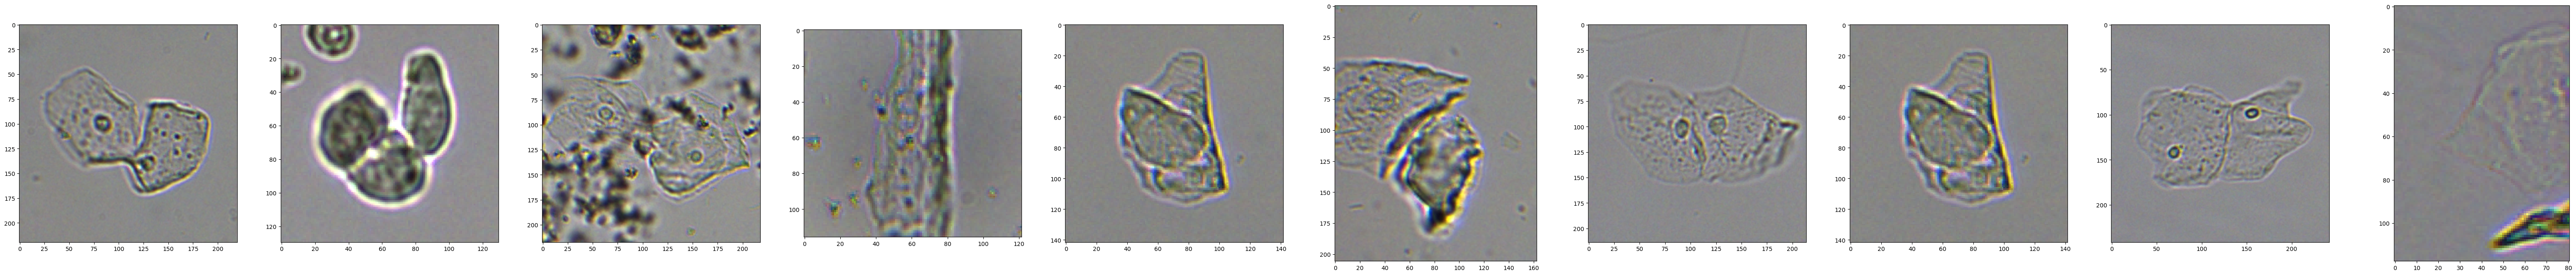

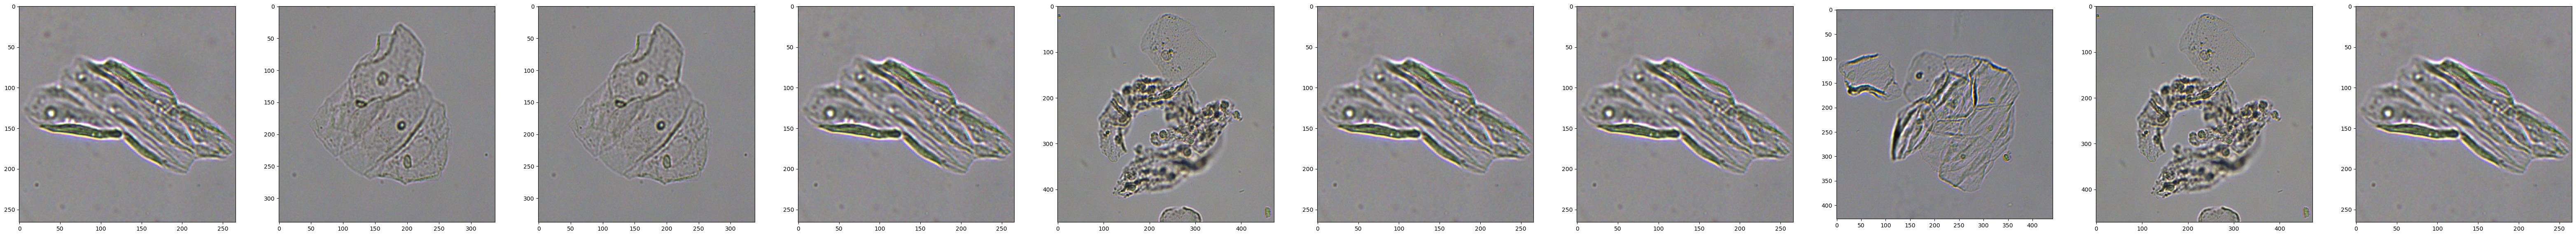

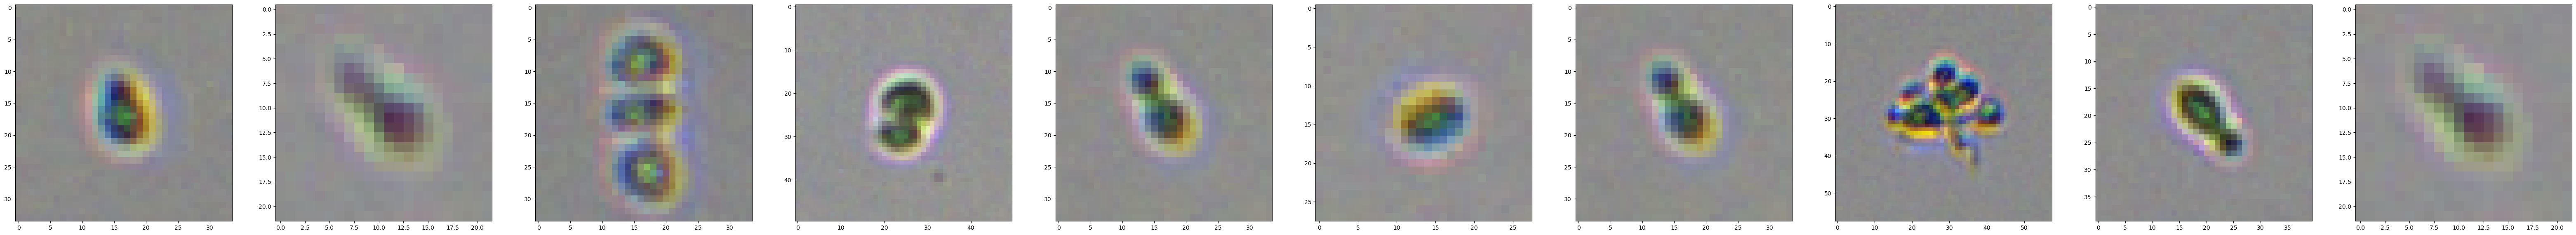

In [20]:
#Now showing some examples from the different groups from our manually labelled multiclass dataset
multiclass_labels  = multiclass_df['label'].unique()

for l in multiclass_labels:
    print("Label: ", l)
    temp = multiclass_df[multiclass_df['label'] == l]
    temp_sample = temp.sample(n=10, replace=True)

    plt.figure(figsize=(80,8))
    i=1
    for index, row in temp_sample.iterrows():
        try:
            img = np.asarray(pil_image.open('../../../ds1/'+row['split']+'/img/cls/'
                                                            +row['img']+'.tif')).astype('uint8')
        except:
            print('Image directory not correct')
            continue
        radius = int(np.ceil(np.sqrt(row['area']/np.pi)))
        # print(radius)

        clip_len = int(np.ceil(1.5*radius)) + 5
        img_height, img_width, _ = img.shape

        #We assume that centroid-0 is y and centroid-1 is x

        img_clipped = img[max(int(row['y']-clip_len), 0): min(int(row['y']+clip_len), img_height),
            max(int(row['x']-clip_len), 0): min(int(row['x']+clip_len), img_width),
            :]

        plt.subplot(1, 10, i)
        plt.imshow(np.squeeze(img_clipped),cmap='gray')
        # plt.savefig(f'<path to save svg for each class>/example_label_{l[6]}.svg')
        i+=1    
    